In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Minibatch implementation in Tensorflow
In this notebook, I show how to store gradients over several minibatches and apply them together in Tensorflow, using the MNIST image set as an example. To demonstrate that this implementation for ONE minibatch is equivalent to the no-minibatch implementation, I overlay the loss/accuracy over iterations for the two (minibatch and no minibatch) settings while seeding all non-deterministic elements and keeping the training-set images the same. You can see that, no matter which optimizer is used, the loss and accuracy curves for two settings overlap.

In [3]:
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(x, W) + b)
y_ = tf.placeholder(tf.float32, [None, 10])

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

In [40]:
sess = tf.InteractiveSession()

# define optimizer
opt = tf.train.GradientDescentOptimizer(0.03)
#opt = tf.train.AdagradOptimizer(0.001)
#opt = tf.train.AdamOptimizer(0.01)
#opt = tf.train.RMSPropOptimizer(0.0003)

# trainable variables
tvs = tf.trainable_variables() 
# create placeholders for the gradients we'll be storing
accum_vars = [tf.Variable(tv.initialized_value(),
                          trainable=False) for tv in tvs]
# ops to initialize accum_vars to zero
zero_ops = [tv.assign(tf.zeros_like(tv)) for tv in accum_vars]
# compute the gradients (example of loss is softmax cross entropy)
gvs = opt.compute_gradients(loss)
# accumulate the gradients of accum_vars
accum_ops = [accum_vars[i].assign_add(gv[0]) for i, gv in enumerate(gvs)]
# perform the update
train_step = opt.apply_gradients([(accum_vars[i], 
                                   tv) for i, tv in enumerate(tf.trainable_variables())])
minimize = opt.minimize(loss)

In [41]:
def get_images(n_minibatches, minibatch_size, n_iterations):
    image_set = []
    for i in range(n_iterations):
        batch = mnist.train.next_batch(batch_size = n_minibatches*minibatch_size,
                                       shuffle=False)
        image_set.append(batch)
    return image_set

In [42]:
def train_minibatch(n_minibatches, minibatch_size, n_iterations, image_set):
    tf.set_random_seed(1234)
    tf.global_variables_initializer().run()
    acc_log = np.zeros(n_iterations)
    loss_log = np.zeros(n_iterations)

    for i in range(n_iterations):
        sess.run(zero_ops)
        batch = image_set[i]
        for j in range(n_minibatches):
            sess.run(accum_ops, 
                     feed_dict={x: batch[0][j*minibatch_size:(j+1)*minibatch_size],
                                y_: batch[1][j*minibatch_size:(j+1)*minibatch_size]})
        acc_log[i] = sess.run(accuracy, 
                              feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        loss_log[i] = sess.run(loss, 
                               feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        sess.run(train_step)
        #print("in iteration {}".format(i), sess.run(accum_vars))
    return acc_log, loss_log

In [43]:
def train_reproduce(batch_size, n_iterations, image_set):
    tf.set_random_seed(1234)
    tf.global_variables_initializer().run()
    acc_log = np.zeros(n_iterations)
    loss_log = np.zeros(n_iterations)

    for i in range(n_iterations):
        batch = image_set[i]
        #print("in iteration {}".format(i), sess.run(opt.compute_gradients(loss), feed_dict={x: batch[0], y_: batch[1]}))
        acc_log[i] = sess.run(accuracy, 
                              feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        loss_log[i] = sess.run(loss, 
                               feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        sess.run(minimize, feed_dict={x: batch[0], y_: batch[1]})
    return acc_log, loss_log

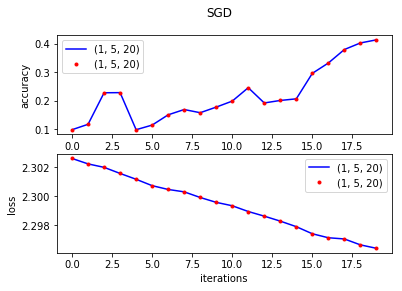

In [27]:
def main():
    n_minibatches = 1
    minibatch_size = 5
    n_iterations = 20
    
    image_set = get_images(n_minibatches, minibatch_size, n_iterations)
    acc_log, loss_log = train_minibatch(n_minibatches, minibatch_size, n_iterations, image_set)
    acc_log2, loss_log2 = train_reproduce(minibatch_size, n_iterations, image_set)
    
    f, axarr = plt.subplots(2)

    f.suptitle("SGD")
    axarr[0].set_ylabel("accuracy")
    axarr[0].set_xlabel("iterations")
    axarr[0].plot(acc_log, 'b', label="({}, {}, {})".format(n_minibatches, minibatch_size, n_iterations))
    axarr[0].plot(acc_log2, 'r.', label="({}, {}, {})".format(1, minibatch_size, n_iterations))
    axarr[0].legend()

    axarr[1].set_ylabel("loss")
    axarr[1].set_xlabel("iterations")
    axarr[1].plot(loss_log, 'b', label="({}, {}, {})".format(n_minibatches, minibatch_size, n_iterations))
    axarr[1].plot(loss_log2, 'r.', label="({}, {}, {})".format(1, minibatch_size, n_iterations))
    axarr[1].legend()

    plt.show()
if __name__ == '__main__':
    main()